# Chapter 12: Parallelizing Neural Network Training with PyTorch  (Part 2/2)


## Building a multilayer perceptron for classifying flowers in the Iris dataset

In [14]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
import torch.nn as nn

Load the Iris dataset, which contains 150 samples of 3 different types of iris
flowers (each 50 samples); each sample has 4 features. 

In [15]:
from sklearn.datasets import load_iris
from sklearn.model_selection import train_test_split 

iris = load_iris()
X = iris['data']
y = iris['target']
 
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=1./3, random_state=1)

In [3]:
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader

X_train_norm = (X_train - np.mean(X_train)) / np.std(X_train)
X_train_norm = torch.from_numpy(X_train_norm).float()
y_train = torch.from_numpy(y_train) 

train_ds = TensorDataset(X_train_norm, y_train)

torch.manual_seed(1)
batch_size = 2
train_dl = DataLoader(train_ds, batch_size, shuffle=True)

In [8]:
class Model(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super().__init__()
        self.layer1 = nn.Linear(input_size, hidden_size)  
        self.layer2 = nn.Linear(hidden_size, output_size)  

    def forward(self, x):
        x = self.layer1(x)
        x = nn.Sigmoid()(x)
        x = self.layer2(x)
        x = nn.Softmax(dim=1)(x)
        return x
    
input_size = X_train_norm.shape[1]
hidden_size = 10
output_size = 3
 
model = Model(input_size, hidden_size, output_size)

learning_rate = 0.001

loss_fn = nn.CrossEntropyLoss()
 
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)


In [9]:
num_epochs = 100
loss_hist = [0] * num_epochs
accuracy_hist = [0] * num_epochs

for epoch in range(num_epochs):

    for x_batch, y_batch in train_dl:
        pred = model(x_batch)
        loss = loss_fn(pred, y_batch.long())
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()
    
        loss_hist[epoch] += loss.item()*y_batch.size(0)
        is_correct = (torch.argmax(pred, dim=1) == y_batch).float()
        accuracy_hist[epoch] += is_correct.sum()
        
    loss_hist[epoch] /= len(train_dl.dataset)
    accuracy_hist[epoch] /= len(train_dl.dataset)

pred = model(x_batch): feedforward step to compute the output for each given input in x_batch

loss.backward(): backward propagation step to compute the gradient of the loss fucntion, dloss/dx, with respect to every parameter x (weights and bias), which has requires_grad=True

optimizer.step(): optimizer.step updates the value of parameter x using the gradient x.grad. For example, the SGD optimizer performs: x += -lr * x.grad

 optimizer.zero_grad(): clears x.grad for every parameter x in the optimizer.

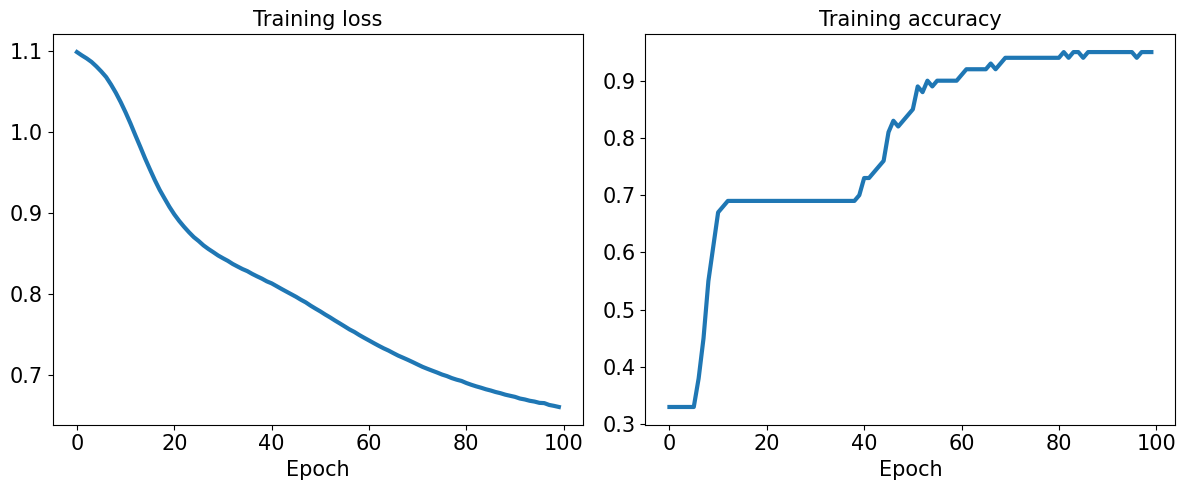

In [10]:
fig = plt.figure(figsize=(12, 5))
ax = fig.add_subplot(1, 2, 1)
ax.plot(loss_hist, lw=3)
ax.set_title('Training loss', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)

ax = fig.add_subplot(1, 2, 2)
ax.plot(accuracy_hist, lw=3)
ax.set_title('Training accuracy', size=15)
ax.set_xlabel('Epoch', size=15)
ax.tick_params(axis='both', which='major', labelsize=15)
plt.tight_layout()

#plt.savefig('figures/12_09.pdf')
 
plt.show()

### Evaluating the trained model on the test dataset

In [13]:
X_test_norm = (X_test - np.mean(X_train)) / np.std(X_train)
X_test_norm = torch.from_numpy(X_test_norm).float()
y_test = torch.from_numpy(y_test) 
pred_test = model(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')


TypeError: expected np.ndarray (got Tensor)

### Saving and reloading the trained model

In [17]:
path = 'iris_classifier.pt'
torch.save(model, path)

In [18]:
model_new = torch.load(path)
model_new.eval()

Model(
  (layer1): Linear(in_features=4, out_features=16, bias=True)
  (layer2): Linear(in_features=16, out_features=3, bias=True)
)

In [19]:
pred_test = model_new(X_test_norm)

correct = (torch.argmax(pred_test, dim=1) == y_test).float()
accuracy = correct.mean()
 
print(f'Test Acc.: {accuracy:.4f}')

Test Acc.: 0.9800


In [20]:
path = 'iris_classifier_state.pt'
torch.save(model.state_dict(), path)